A selection of white dwarfs with double-peaked Ca II emmison were observed with LRS2 on HET during December 2021 -- March 2022. Here I calculate the equivalent width of the lines in each observation. 

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as fits
import os
import glob
from astropy.table import Table
from astropy.io import ascii
import astropy.units as u
import astropy.constants as const
from astropy.convolution import convolve, Box1DKernel
from scipy.interpolate import interp1d
from astropy.modeling import models, fitting
from astropy.time import Time

#matplotlib set up
%matplotlib inline
from matplotlib import rcParams
rcParams["figure.figsize"] = (14, 5)
rcParams["font.size"] = 20

In [10]:
hetpath = '/media/david/2tb_ext_hd/hddata/het_gas/UT22-1-013/'

hetspecs = glob.glob('{}spectrum*d.fits'.format(hetpath)) #just the red arm
# hetspecs

In [11]:
# fits.getheader(hetspecs[1])

List of observed stars:

In [12]:
stars = []
for spec in hetspecs:
    data = fits.getdata(spec)
    star = fits.getheader(spec)['QOBJECT']
    # print(star)
    stars.append(star)
stars = np.unique(stars)
print(stars)

['WDJ0147+2339' 'WDJ0347+1624' 'WDJ0845+2257' 'WDJ0846+5703'
 'WDJ1622+5840']


In [6]:
def wavelength_edges(w):
    """
    Calulates the edges of each wavelength bin w0, w1
    """
    diff = np.diff(w)
    diff0 = np.concatenate((np.array([diff[0]]), diff)) #adds an extravalue to make len(diff) = len(w)
    diff1 = np.concatenate((diff, np.array([diff[-1]]))) #adds an extravalue to make len(diff) = len(w)
    w0 = w - diff0/2.
    w1 = w + diff1/2.
    return w0, w1

def spectra_adder(f_array, e_array, rcs = True):
    """
    Returns a variance-weighted coadd with standard error of the weighted mean (variance weights, scale corrected).
    f_array and e_arrays are collections of flux and error arrays, which should have the same lenth and wavelength scale
    """
    weights = 1 / (e_array**2)
    flux = np.average(f_array, axis =0, weights = weights)
    var = 1 / np.sum(weights, axis=0)
    if rcs:
        rcs = np.sum((((flux - f_array)**2) * weights), axis=0) / (len(f_array)-1) #reduced chi-squared
        error = (var * rcs)**0.5
    else:
        error = var**0.5
    return flux, error

def make_plot_spec(w, f, e, triplet_edges, waveband=[8400, 8800], smooth=10): #cuts spectrum down to the bit to plot
    """
    Normalises the spectrum around the Caii lines. Waveband is the strech of spectrum to return. Triplet gives the regions to include when normalising.
    """
    fitter = fitting.LinearLSQFitter()
    tripmask = (w > triplet_edges[0]) & (w < triplet_edges[1]) | (w > triplet_edges[2]) & (w < triplet_edges[3]) | (w > triplet_edges[4]) & (w < triplet_edges[5]) | (w > triplet_edges[6]) & (w < triplet_edges[7])  
    w1, f1, e1 = w[tripmask], f[tripmask], e[tripmask]
    n_init = models.Polynomial1D(3)
    n_fit = fitter(n_init, w1, f1)
    nf = f/n_fit(w)
    ne = e/n_fit(w)
    if smooth == 0:
        smooth = 1
    nf = convolve(nf,Box1DKernel(smooth))
    ne = convolve(ne,Box1DKernel(smooth))/smooth**0.5
    bandmask = (w >= waveband[0]) & (w < waveband[1])
    w1, f1, e1 = w[bandmask], nf[bandmask], ne[bandmask]
    return w1,f1, e1

def norm_equivalent_width(w, f, e, bandpass):
    """
    Measures the equivalent width of a continumn-normalised spectrum in the gap bandpass
    """
    mask = (w >= bandpass[0]) & (w <= bandpass[1]) 
    w, f, e = w[mask], f[mask], e[mask]
    w0, w1 = wavelength_edges(w)
    eqw = np.sum((1-f)*(w1-w0))
    eqw_e=((1.+(1./np.mean(f)))**(0.5)) * (((w[-1]-w[0])-eqw)/(np.mean(f)/np.mean(e)))
    return eqw, eqw_e

Approximate edges of each emission line measured by eye. The first and last values are the entire region over which the normalisation was performed.

In [32]:
triplet_regions = {'WDJ0846+5703':[8400, 8480, 8520, 8522, 8565, 8638, 8685, 8750],
                   'WDJ0845+2257':[8400, 8480, 8525, 8525, 8565, 8645,8685,8750],
                   'WDJ0347+1624':[8400, 8475, 8515, 8522, 8565, 8640, 8685, 8750],
                   'WDJ0147+2339':[8400, 8475, 8521, 8522, 8565, 8635, 8690, 8750],
                   'WDJ1622+5840':[8400, 8470, 8520, 8521, 8570, 8635, 8690, 8750]}

# trips2 = [[8480,8525], [8525,8565], [8645, 8685]]


The below cell sorts the spectra by star and date. Spectra obtained on the same night are coadded, then continumn-normalised. The equivalent width of each line is then caculated, with the sum of all three lines given as the final result. A plot of all observations is made for each star, and tables of MJD, equivalent width and equivalent width uncertainty saved for each star.

WDJ0147+2339
2021-12-16
0.7384385185235942
0.6584575285506016
0.9076285589760312
2022-01-03


 [astropy.modeling.fitting]
 [astropy.modeling.fitting]
 [astropy.modeling.fitting]


2.141305904035144
1.9618995590887676
2.583553601003009
2022-01-17
1.566166581580966
1.3959329915300664
1.8818113936517453
WDJ0347+1624
2022-02-09
5.686352756209756
5.82703864271886
6.1560516809173835
2022-02-11


 [astropy.modeling.fitting]
 [astropy.modeling.fitting]
 [astropy.modeling.fitting]


3.616372917341284
4.206758617703806
4.008904553429137
2022-02-21
1.0883187681158468
0.8881956475468333
1.3662166228826913
WDJ0845+2257
2021-12-29
1.867488099573898
1.5606887263131086
1.9500488808467455
2022-01-23


 [astropy.modeling.fitting]
 [astropy.modeling.fitting]
 [astropy.modeling.fitting]


2.0151549938238804
2.1115524785719817
1.8001184063322826
2022-02-10
1.9516769353238
1.821121796299221
1.572608611142207
2022-02-27
0.3769519034350872
0.3376769995734873
0.5358240280506759


 [astropy.modeling.fitting]


WDJ0846+5703
2022-02-10
3.2390057243838886
3.444852159450766
3.965045958246642
2022-02-28


 [astropy.modeling.fitting]
 [astropy.modeling.fitting]
 [astropy.modeling.fitting]


3.2468698063049297
3.5219902701039967
4.07570712120143
2022-03-11
0.8966936186131399
0.8695960663512662
1.2405137174575662
WDJ1622+5840
2022-02-13
1.7457349069427175
1.8604723849797207
1.9232449264802867


 [astropy.modeling.fitting]


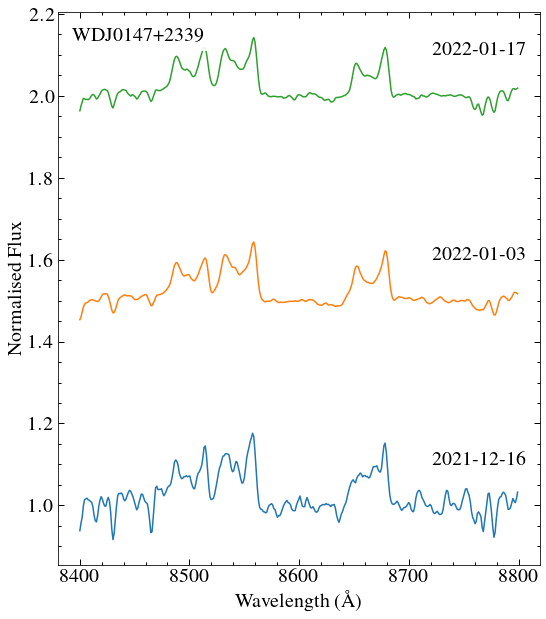

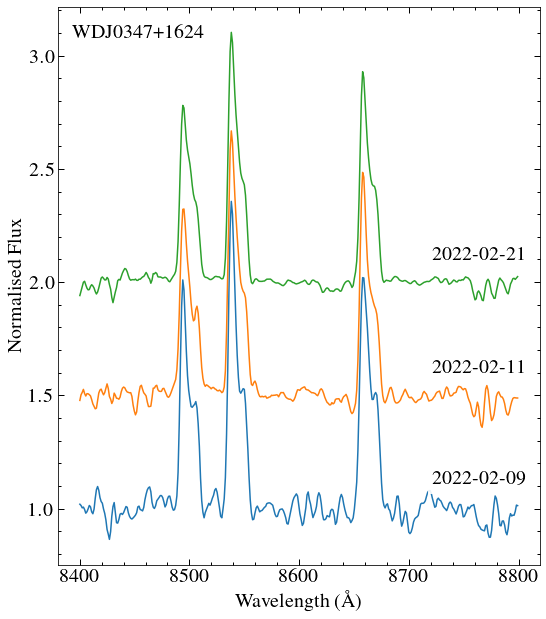

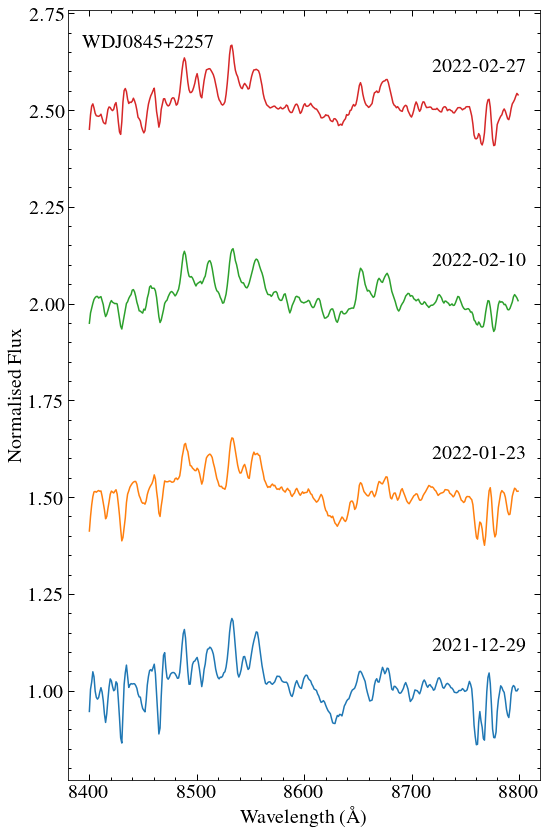

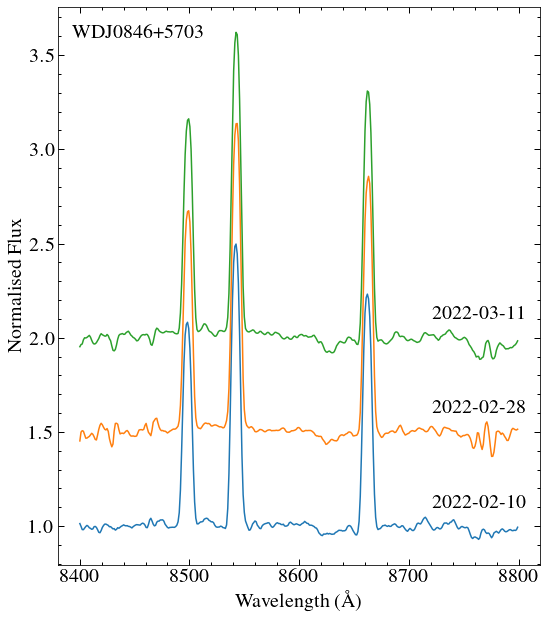

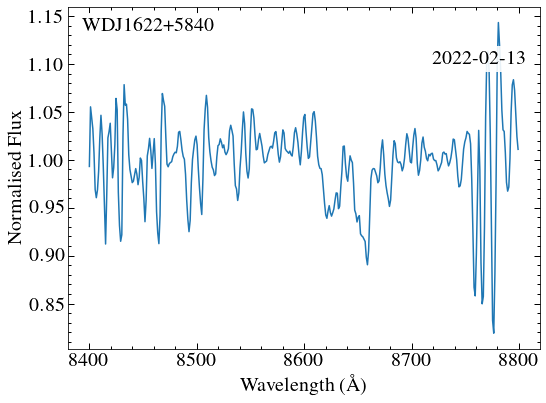

In [35]:
smooth = 4 #boxcar smoothing window
for star in stars:
    mjds = []
    equivalent_widths  = []
    equivalent_width_errors = []
    
    print(star)
    dates = []
    for spec in hetspecs:
        hdr = fits.getheader(spec)
        if hdr['QOBJECT'] == star:
            dates.append(hdr['DATE-OBS'])
    dates = np.unique(dates)
    dates = dates[np.argsort(dates)]
    ysize = max([len(dates)*3, 6])
    plt.figure(figsize=(8, ysize))
    for i, date in enumerate(dates):
        print(date)
        fs  = [] #arrays to put fluxes and errors in to coadd, wavelength grid is the same for each spectrum
        es = []
        for spec in hetspecs:
            hdr = fits.getheader(spec)
            if hdr['DATE-OBS'] == date and hdr['QOBJECT'] == star and hdr['WAVE0'] > 8000:
                data = fits.getdata(spec)
                w, fi, ei = data[0], data[1], data[3]
                fs.append(fi)
                es.append(ei)
        if len(np.array(fs)) >1:
            f, e = spectra_adder(np.array(fs), np.array(es), rcs = True)
        else:
            f, e = fi, ei
        trips = triplet_regions[star]
        # mask = (w > 8400) & (w < 8750)
        nw,nf, ne = make_plot_spec(w, f, e, triplet_regions[star], smooth=4)
        scale = 1
        if max(nf < 1.5):
            scale=0.5
        
        plt.plot(nw, nf+i*scale)
        plt.annotate(date, (0.97, 1.1+i*scale), xycoords= ('axes fraction', 'data'), ha='right', bbox=dict(facecolor='white', edgecolor='none', alpha=0.9))
           
        date = Time(date)
        mjds.append(date.mjd)
        eqws = []
        eqwes = []
        for b, r in zip(trips[1::2][:-1], trips[2::2]):
            eqw, eqwe = norm_equivalent_width(nw, nf, ne, [b,r])
            print(eqwe)
            eqws.append(eqw)
            eqwes.append(eqwe)
        
        equivalent_widths.append(np.sum(eqws))
        equivalent_width_errors.append(np.sum(np.array(eqwes)**2)**0.5)
    

    plt.annotate(star, (0.03, 0.97), xycoords= ('axes fraction'), ha='left', va='top', bbox=dict(facecolor='white', edgecolor='none', alpha=0.9))
    plt.xlabel('Wavelength (\AA)')
    plt.ylabel('Normalised Flux')
    plt.tight_layout()
    plt.savefig('plots/{}_lrs2_caiitriplets.png'.format(star), facecolor='w')
    plt.savefig('plots/{}_lrs2_caiitriplets.pdf'.format(star))

    savdat = Table([mjds, equivalent_widths, equivalent_width_errors], names = ['#MJD', 'EW', 'EW_ERROR'])
    ascii.write(savdat, 'het_results/{}_lrs2_ews.dat'.format(star), format='basic', overwrite=True)

    # plt.show()
    

                

Finally, a plot of all of the measured equivalent widths.

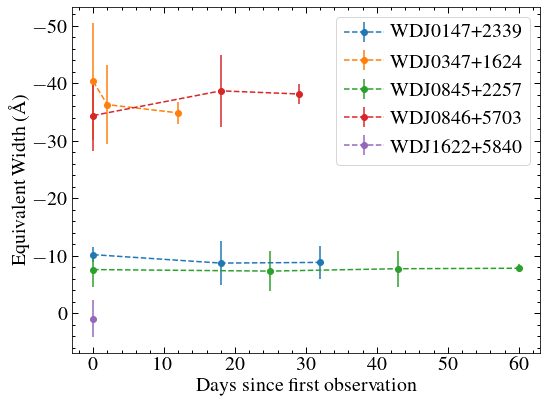

In [34]:
plt.figure(figsize=(8,6))
for star in stars:
    mjd, ew, ewe = np.loadtxt('het_results/{}_lrs2_ews.dat'.format(star), unpack=True)
    if type(mjd) == np.ndarray:
        mjd -=mjd[0]
    else:
        mjd=0
    plt.errorbar(mjd, ew, yerr=ewe, ls='--', marker='o', label=star)
plt.legend(frameon = True)
plt.xlabel('Days since first observation')
plt.ylabel ('Equivalent Width (\AA)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig('plots/all_lrs_ews.png', facecolor='w')
plt.savefig('plots/all_lrs_ews.pdf')

Initial conclusions: The net strength of the emisson remained constant for all stars over the campaign. Non-dectection at WDJ1622+5840. The most notable result (not shown here) is the continued decrease in strength of the lines as WDJ0845+2257.